<a href="https://colab.research.google.com/github/MedSalimBenOmrane/ppp/blob/main/screw_anomalies_autoencoder_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Screw Anomalies Autoencoder

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224,224)), # Unify images to (224,224) size
    transforms.ToTensor()
])

train_dir='/screw/train'
test_dir='/screw/test'

train_dataset = ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
class_names = test_dataset.classes
print(class_names)

['good', 'manipulated_front', 'scratch_head', 'scratch_neck', 'thread_side', 'thread_top']


In [ ]:
train_loader_shape = (len(train_loader.dataset), ) + train_loader.dataset[0][0].shape

# Get the shape of the test loader
test_loader_shape = (len(test_loader.dataset), ) + test_loader.dataset[0][0].shape

# Print the shapes
print("Train Loader Shape:", train_loader_shape)
print("Test Loader Shape:", test_loader_shape)


Train Loader Shape: (320, 3, 224, 224)
Test Loader Shape: (160, 3, 224, 224)


In [ ]:
num_batches_to_display = 3

# Iterate over the first few batches
for batch_idx, (data, target) in enumerate(train_loader):
    if batch_idx >= num_batches_to_display:
        break
    
    # Print the batch index and the data tensor
    print("Batch", batch_idx)
    print(data)
    print("---")

Batch 0
tensor([[[[0.8588, 0.8549, 0.8510,  ..., 0.8745, 0.8745, 0.8824],
          [0.8510, 0.8510, 0.8510,  ..., 0.8784, 0.8745, 0.8745],
          [0.8549, 0.8549, 0.8549,  ..., 0.8863, 0.8824, 0.8824],
          ...,
          [0.8314, 0.8353, 0.8275,  ..., 0.8392, 0.8353, 0.8392],
          [0.8275, 0.8275, 0.8275,  ..., 0.8471, 0.8471, 0.8392],
          [0.8314, 0.8314, 0.8235,  ..., 0.8431, 0.8471, 0.8431]],

         [[0.8588, 0.8549, 0.8510,  ..., 0.8745, 0.8745, 0.8824],
          [0.8510, 0.8510, 0.8510,  ..., 0.8784, 0.8745, 0.8745],
          [0.8549, 0.8549, 0.8549,  ..., 0.8863, 0.8824, 0.8824],
          ...,
          [0.8314, 0.8353, 0.8275,  ..., 0.8392, 0.8353, 0.8392],
          [0.8275, 0.8275, 0.8275,  ..., 0.8471, 0.8471, 0.8392],
          [0.8314, 0.8314, 0.8235,  ..., 0.8431, 0.8471, 0.8431]],

         [[0.8588, 0.8549, 0.8510,  ..., 0.8745, 0.8745, 0.8824],
          [0.8510, 0.8510, 0.8510,  ..., 0.8784, 0.8745, 0.8745],
          [0.8549, 0.8549, 0.8549,

##build the autoencoder##

In [ ]:
# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Instantiate Autoencoder and send to GPU
autoencoder = Autoencoder().to(device)

# Definition of loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

## train the autoencoder


In [ ]:
# training
list_loss=[]
for epoch in range(100):
    running_loss = 0.0
    for data in train_loader:
        img, _ = data
        img = Variable(img).to(device)
        optimizer.zero_grad()
        outputs = autoencoder(img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        list_loss.append(loss.item())
    print('Epoch [%d], Loss: %.4f' % (epoch+1, running_loss/len(train_loader)))

# test
autoencoder.eval()

test_loss =0.0 
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = Variable(img).to(device)
        outputs = autoencoder(img)
        loss = criterion(outputs, img)
        test_loss += loss.item()
    print('Test Loss: %.4f' % (test_loss/len(test_loader)))

Epoch [1], Loss: 0.3885
Epoch [2], Loss: 0.2240
Epoch [3], Loss: 0.0739
Epoch [4], Loss: 0.0260
Epoch [5], Loss: 0.0148
Epoch [6], Loss: 0.0117
Epoch [7], Loss: 0.0101
Epoch [8], Loss: 0.0090
Epoch [9], Loss: 0.0079
Epoch [10], Loss: 0.0068
Epoch [11], Loss: 0.0054
Epoch [12], Loss: 0.0041
Epoch [13], Loss: 0.0032
Epoch [14], Loss: 0.0028
Epoch [15], Loss: 0.0026
Epoch [16], Loss: 0.0024
Epoch [17], Loss: 0.0022
Epoch [18], Loss: 0.0021
Epoch [19], Loss: 0.0020
Epoch [20], Loss: 0.0019
Epoch [21], Loss: 0.0018
Epoch [22], Loss: 0.0017
Epoch [23], Loss: 0.0017
Epoch [24], Loss: 0.0016
Epoch [25], Loss: 0.0016
Epoch [26], Loss: 0.0015
Epoch [27], Loss: 0.0015
Epoch [28], Loss: 0.0015
Epoch [29], Loss: 0.0014
Epoch [30], Loss: 0.0014
Epoch [31], Loss: 0.0014
Epoch [32], Loss: 0.0014
Epoch [33], Loss: 0.0014
Epoch [34], Loss: 0.0013
Epoch [35], Loss: 0.0013
Epoch [36], Loss: 0.0013
Epoch [37], Loss: 0.0013
Epoch [38], Loss: 0.0013
Epoch [39], Loss: 0.0013
Epoch [40], Loss: 0.0013
Epoch [41

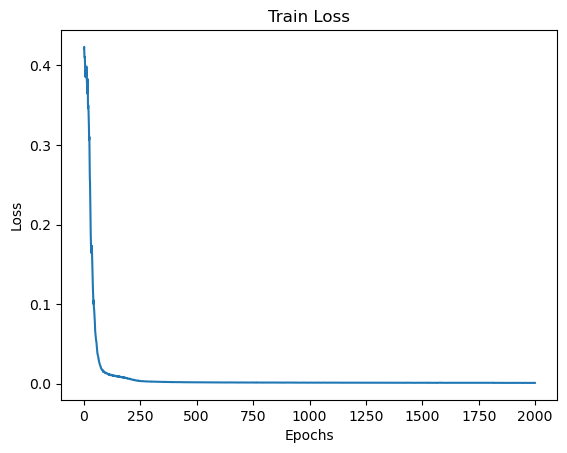

In [ ]:
plt.figure()
plt.plot(list_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('deep_ae_mnist_loss.png')

In [ ]:
mse = 0.0

with torch.no_grad():
    for data in test_loader:
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = autoencoder(inputs)
        mse += torch.mean((outputs - targets) ** 2).item()

test_score = mse / len(test_loader)
print(test_score)

5.324681715341285


In [ ]:
#### comparison bertween classes in test data
autoencoder.eval()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
class_encodings = [[] for i in range(6)]
with torch.no_grad():
    for data in test_loader:
        img, label = data
        img = Variable(img).to(device)
        encoding = autoencoder.encoder(img)
        class_encodings[label.item()].append(encoding.cpu().numpy().ravel())

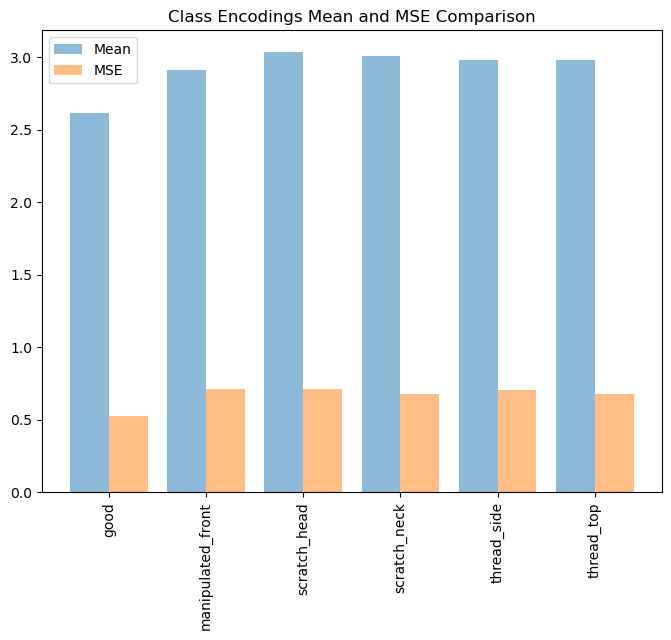

In [ ]:
class_means = []
class_mses = []
for i in range(6):
    class_means.append(np.mean(class_encodings[i]))
    class_mse = np.mean((class_encodings[i] - class_means[i])**2)
    class_mses.append(class_mse)

plt.figure(figsize=(8, 6))
plt.bar(np.arange(6)-0.2, class_means, width=0.4, label='Mean', alpha=0.5)
plt.bar(np.arange(6)+0.2, class_mses, width=0.4, label='MSE', alpha=0.5)
plt.xticks(range(6), class_names, rotation=90)
plt.legend()
plt.title("Class Encodings Mean and MSE Comparison")
plt.show()